In [2]:
import os
os.environ["KERAS_BACKEND"] = "torch"


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms


In [4]:
from keras import layers, optimizers, losses, metrics, Model, Sequential, callbacks

In [5]:
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=False)

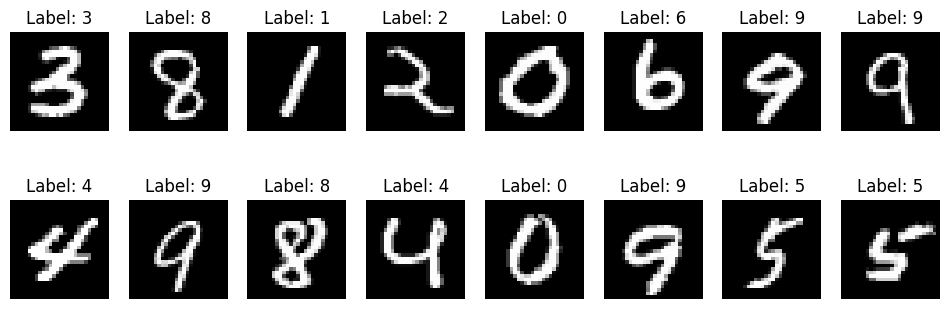

In [13]:
images_count = 0
for images, labels in train_loader:
    plt.figure(figsize=(12,4))
    for i in range(16):
        plt.subplot(2,8,i+1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.axis('off')
        plt.title(f'Label: {labels[i].item()}')
    plt.show()
    images_count += len(images)
    if images_count >= 10:
        break


Create the autoencoder class

In [14]:
class AutoEncoder(Model):
    def __init__(self):
        super().__init__()
        self.encoder = Sequential([
            layers.Dense(128, activation='relu', input_shape=(784,)),
            layers.Dense(64, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(32, activation='relu') #latent space
        ])

        self.decoder = Sequential([
            layers.Dense(32, activation='relu', input_shape=(32,)),
            layers.Dense(64, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(784, activation='sigmoid')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        latent = self.latent(encoded)
        decoded = self.decoder(latent)
        return decoded

In [ ]:
model = AutoEncoder()
model.compile(optimizer=optimizers.Adam(learning_rate=1e-3, weight_decay=1e-5), loss=losses.MeanAbsoluteError(), metrics=['accuracy'])
model.summary()

In [ ]:
epochs = 1000

for epoch in range(epochs):
    model.fit(x_train, x_train,
              epochs=1,
              )